In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
from catboost import CatBoostRegressor, Pool
import warnings 
warnings.filterwarnings('ignore')


# Data Prepration 

In [2]:
data = pd.read_parquet('/Users/sameernigam/Desktop/ml-end-end-project/data/raw_data/database.parquet')

In [3]:
data.head()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
data.tail()

,datetime,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
13898,2012-08-07 07:00:00,3,1,8,7,0,2,1,2,0.70,0.6667,0.74,0.1343,21,481,502
13899,2012-08-07 08:00:00,3,1,8,8,0,2,1,2,0.70,0.6515,0.70,0.1642,41,664,705
13900,2012-08-07 09:00:00,3,1,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,44,283,327
13901,2012-08-07 10:00:00,3,1,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,89,161,250
13902,2012-08-07 11:00:00,3,1,8,11,0,2,1,2,0.76,0.7273,0.66,0.0896,84,130,214


In [5]:
drop_cols = ['yr', 'casual', 'registered', 'datetime']

In [6]:
data = data.drop(columns = drop_cols)

In [7]:
data.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


# Baseline Model

Metrics - MAPE = Mean Absolute Percentage Error
        - MAE
        - RMSE

In [8]:
def compute_metrics(y_true, y_pred):

    '''Purpose:
Calculates three common error metrics to evaluate prediction models: MAE, RMSE, and MAPE.

Parameters:

y_true (list or array): The actual true values from your dataset.

y_pred (list or array): The predicted values from your model.'''

    
    mae = mean_absolute_error(y_true, y_pred)
    rmse =  mean_squared_error(y_true, y_pred, squared = False)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 0.01, y_true))) * 100


    return{
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE': round(mape, 2)
    }
    


In [9]:
data.shape[0]

13903

In [10]:
def prepare_dataset(df, train_fraction):
    feats  = [col for col in df.columns if col!= 'target']
    x, y = df[feats], df['target']
    train_size = int(train_fraction * df.shape[0])
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return x_train, x_test, y_train, y_test
    

# Target Defination

In [11]:
df = data.copy()

In [12]:
df['target'] = df['cnt'].shift(-1).fillna(method = 'ffill')
df.drop(columns = ['cnt'], inplace = True)

In [13]:
df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,target
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,40.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,32.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,13.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,1.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1.0


In [14]:
df.tail()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,target
13898,3,8,7,0,2,1,2,0.70,0.6667,0.74,0.1343,705.0
13899,3,8,8,0,2,1,2,0.70,0.6515,0.70,0.1642,327.0
13900,3,8,9,0,2,1,2,0.70,0.6667,0.74,0.1343,250.0
13901,3,8,10,0,2,1,2,0.74,0.6970,0.70,0.1343,214.0
13902,3,8,11,0,2,1,2,0.76,0.7273,0.66,0.0896,214.0


In [15]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction = 0.8)

In [16]:
%%time
model = RF(n_estimators = 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

CPU times: user 2.15 s, sys: 40.3 ms, total: 2.19 s
Wall time: 2.19 s


In [17]:
metrics_base = compute_metrics(y_test.values, y_pred)
metrics_base

{'MAE': 84.9, 'RMSE': 116.25, 'MAPE': 34.59}

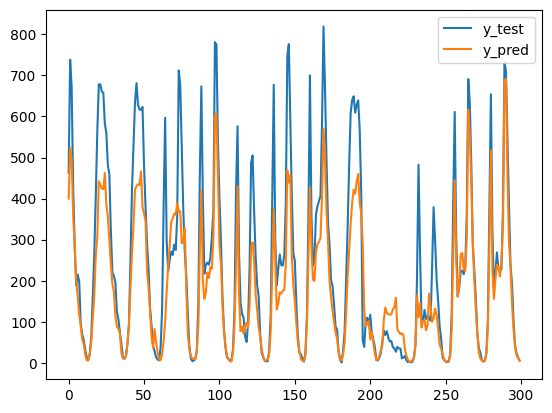

In [18]:
n = 300
plt.plot(y_test.values[:n], label = 'y_test')
plt.plot(y_pred[:n], label = 'y_pred')
plt.legend()

# Dummy Model

In [19]:
y_dummy = y_test.shift(1).fillna(method = 'bfill') #naive or persistance model

In [20]:
y_dummy

11122    463.0
11123    463.0
11124    738.0
11125    671.0
11126    427.0
         ...  
13898    502.0
13899    705.0
13900    327.0
13901    250.0
13902    214.0
Name: target, Length: 2781, dtype: float64

In [21]:
y_test

11122    463.0
11123    738.0
11124    671.0
11125    427.0
11126    286.0
         ...  
13898    705.0
13899    327.0
13900    250.0
13901    214.0
13902    214.0
Name: target, Length: 2781, dtype: float64

In [22]:
metrics_dummy = compute_metrics(y_test.values, y_dummy)

In [23]:
metrics_dummy

{'MAE': 87.01, 'RMSE': 128.17, 'MAPE': 55.4}

In [24]:
metrics_base

{'MAE': 84.9, 'RMSE': 116.25, 'MAPE': 34.59}

# Baseline Model with target lag features

In [25]:
for lag in range(1, 25):
    print(f"Lag {lag}: {df['target'].autocorr(lag = lag):.3f}")

Lag 1: 0.845
Lag 2: 0.597
Lag 3: 0.407
Lag 4: 0.274
Lag 5: 0.146
Lag 6: 0.010
Lag 7: -0.094
Lag 8: -0.114
Lag 9: -0.058
Lag 10: -0.049
Lag 11: -0.100
Lag 12: -0.131
Lag 13: -0.105
Lag 14: -0.057
Lag 15: -0.058
Lag 16: -0.094
Lag 17: -0.065
Lag 18: 0.033
Lag 19: 0.153
Lag 20: 0.262
Lag 21: 0.371
Lag 22: 0.520
Lag 23: 0.705
Lag 24: 0.809


In [26]:
df = data.copy()

In [27]:
df['target'] = df['cnt'].shift(-1).fillna(method = 'ffill')

In [28]:
df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1.0


In [29]:
for i in range(1,3):
    df[f'cnt_lag_{i}'] = df['cnt'].shift(i).fillna(method = 'bfill')

for i in range(22, 24):
    df[f'cnt_lag_{i}'] = df['cnt'].shift(i).fillna(method = 'bfill')

In [30]:
df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,target,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,40.0,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,32.0,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,13.0,40.0,16.0,16.0,16.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,1.0,32.0,40.0,16.0,16.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,1.0,13.0,32.0,16.0,16.0


In [31]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction = 0.8)

In [32]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,cnt_lag_1,cnt_lag_2,cnt_lag_22,cnt_lag_23
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,16.0,16.0,16.0,16.0
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,16.0,16.0,16.0,16.0
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,40.0,16.0,16.0,16.0
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,32.0,40.0,16.0,16.0
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,13.0,32.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,0.1940,192,330.0,563.0,259.0,224.0
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,0.1343,233,192.0,330.0,203.0,259.0
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,0.0000,322,233.0,192.0,224.0,203.0
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,0.2836,358,322.0,233.0,211.0,224.0


In [33]:
%%time
model = RF(n_estimators = 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

CPU times: user 4.73 s, sys: 91.6 ms, total: 4.82 s
Wall time: 4.62 s


In [34]:
metrics_target_lag = compute_metrics(y_test.values, y_pred)
metrics_target_lag

{'MAE': 43.65, 'RMSE': 71.36, 'MAPE': 24.63}

In [35]:
print('Dummy Model Score:- ', metrics_dummy)
print('Baseline model scores:- ', metrics_base)
print('Baseline Model with target lags score:- ', metrics_target_lag)


Dummy Model Score:-  {'MAE': 87.01, 'RMSE': 128.17, 'MAPE': 55.4}
Baseline model scores:-  {'MAE': 84.9, 'RMSE': 116.25, 'MAPE': 34.59}
Baseline Model with target lags score:-  {'MAE': 43.65, 'RMSE': 71.36, 'MAPE': 24.63}


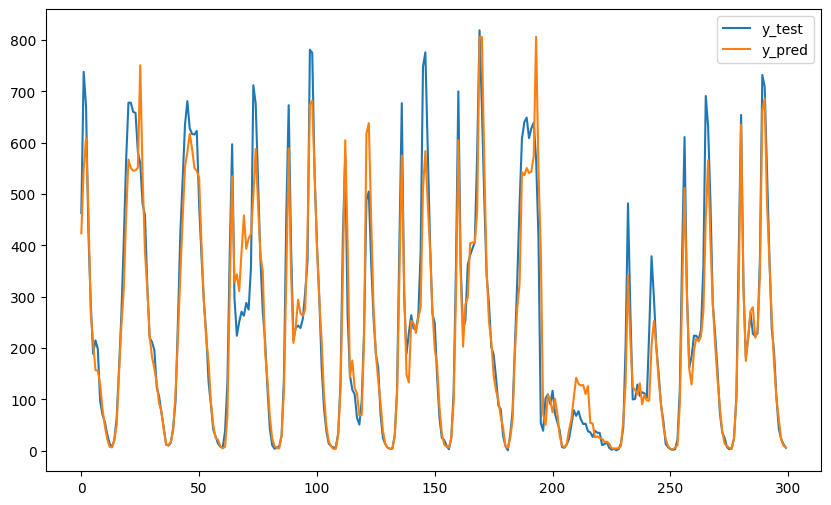

In [36]:
n = 300
plt.figure(figsize = (10,6))
plt.plot(y_test.values[:n], label = 'y_test')
plt.plot(y_pred[:n],label = 'y_pred')
plt.legend()

# Baseline model with all lag features

In [37]:
df.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'target',
       'cnt_lag_1', 'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23'],
      dtype='object')

In [38]:
lag_feats = ['hr', 'weekday', 'weathersit', 'temp', 'hum']

In [39]:
n = 3

for feat in lag_feats:
    for i in range(1,n+1):
        df[f'{feat}_lag_{i}'] = df[feat].shift(i).fillna(method = 'bfill')

In [40]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction = 0.8)

In [41]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,...,5.0,1.0,1.0,1.0,0.42,0.38,0.34,0.41,0.46,0.61
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,...,5.0,1.0,1.0,1.0,0.44,0.42,0.38,0.38,0.41,0.46
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,...,5.0,1.0,1.0,1.0,0.46,0.44,0.42,0.36,0.38,0.41
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,...,5.0,1.0,1.0,1.0,0.50,0.46,0.44,0.31,0.36,0.38


In [42]:
x_train.columns

Index(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt', 'cnt_lag_1',
       'cnt_lag_2', 'cnt_lag_22', 'cnt_lag_23', 'hr_lag_1', 'hr_lag_2',
       'hr_lag_3', 'weekday_lag_1', 'weekday_lag_2', 'weekday_lag_3',
       'weathersit_lag_1', 'weathersit_lag_2', 'weathersit_lag_3',
       'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'hum_lag_1', 'hum_lag_2',
       'hum_lag_3'],
      dtype='object')

In [43]:
%%time
model = RF(n_estimators = 100, verbose = 1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.9s


CPU times: user 8.2 s, sys: 146 ms, total: 8.34 s
Wall time: 8.02 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [44]:
metrics_all_feat_lags = compute_metrics(y_test.values, y_pred)
metrics_all_feat_lags

{'MAE': 43.81, 'RMSE': 71.28, 'MAPE': 24.26}

In [45]:
print('Dummy Model Score:- ', metrics_dummy)
print('Baseline model scores:- ', metrics_base)
print('Baseline Model with target lags score:- ', metrics_target_lag)
print('Baseline Model with all feat lags score:- ', metrics_all_feat_lags)


Dummy Model Score:-  {'MAE': 87.01, 'RMSE': 128.17, 'MAPE': 55.4}
Baseline model scores:-  {'MAE': 84.9, 'RMSE': 116.25, 'MAPE': 34.59}
Baseline Model with target lags score:-  {'MAE': 43.65, 'RMSE': 71.36, 'MAPE': 24.63}
Baseline Model with all feat lags score:-  {'MAE': 43.81, 'RMSE': 71.28, 'MAPE': 24.26}


# Gradient Boosting with Hyperparameters Tuning

In [46]:
df.reset_index(drop = True, inplace = True)

In [47]:
df.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80


In [48]:
x_train, x_test, y_train, y_test = prepare_dataset(df, train_fraction = 0.8)

In [49]:
x_train

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,weekday_lag_3,weathersit_lag_1,weathersit_lag_2,weathersit_lag_3,temp_lag_1,temp_lag_2,temp_lag_3,hum_lag_1,hum_lag_2,hum_lag_3
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.24,0.24,0.24,0.81,0.81,0.81
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,...,6.0,1.0,1.0,1.0,0.22,0.24,0.24,0.80,0.81,0.81
3,1,1,3,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.22,0.22,0.24,0.80,0.80,0.81
4,1,1,4,0,6,0,1,0.24,0.2879,0.75,...,6.0,1.0,1.0,1.0,0.24,0.22,0.22,0.75,0.80,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11117,2,4,10,0,5,1,1,0.44,0.4394,0.38,...,5.0,1.0,1.0,1.0,0.42,0.38,0.34,0.41,0.46,0.61
11118,2,4,11,0,5,1,1,0.46,0.4545,0.36,...,5.0,1.0,1.0,1.0,0.44,0.42,0.38,0.38,0.41,0.46
11119,2,4,12,0,5,1,1,0.50,0.4848,0.31,...,5.0,1.0,1.0,1.0,0.46,0.44,0.42,0.36,0.38,0.41
11120,2,4,13,0,5,1,1,0.52,0.5000,0.27,...,5.0,1.0,1.0,1.0,0.50,0.46,0.44,0.31,0.36,0.38


In [52]:
#Step 1 -> Defining Optuna objective with TimeSeriesSplit on x_train
#Optuna uses Baysian Optimisation methods in order to tune the hyperparameters.

def objective(trial):
    np.random.seed(42)
    params = {"learning_rate": trial.suggest_float("learning_rate", 0.01,0.2), 
              "depth": trial.suggest_int('depth', 3,8), #model complexity
              'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.5,5),#prevent overfitting
              'iterations':1000,
              'loss_function':'RMSE',
              'verbose':0
    }

    train_idx = int(0.85 * x_train.shape[0])
    
    x_tr, x_val = x_train.iloc[:train_idx], x_train.iloc[train_idx:]
    y_tr, y_val = y_train.iloc[:train_idx], y_train.iloc[train_idx:]

    model = CatBoostRegressor(**params,random_seed = 42)
    model.fit(x_tr, y_tr,
        eval_set = (x_val, y_val),
        early_stopping_rounds = 100,
        use_best_model = True)

    preds = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))


    trial.set_user_attr("best_iteration", model.get_best_iteration())

    return rmse

    

In [53]:
#Step 2 -> Run the Optuna

study = optuna.create_study(direction = 'minimize', sampler = optuna.samplers.TPESampler(seed = 42))
study.optimize(objective, n_trials = 150)

#Step 3-> Train the final model on full x_train with best parameters
best_params = study.best_trial.params


[I 2025-10-10 22:30:42,057] A new study created in memory with name: no-name-1147cc85-88fb-4d1d-a9f3-b7ec49065f71
[I 2025-10-10 22:30:42,662] Trial 0 finished with value: 62.631936201851325 and parameters: {'learning_rate': 0.08116262258099886, 'depth': 8, 'l2_leaf_reg': 3.793972738151323}. Best is trial 0 with value: 62.631936201851325.
[I 2025-10-10 22:30:42,876] Trial 1 finished with value: 60.80780968109356 and parameters: {'learning_rate': 0.12374511199743694, 'depth': 3, 'l2_leaf_reg': 1.201975341512912}. Best is trial 1 with value: 60.80780968109356.
[I 2025-10-10 22:30:44,135] Trial 2 finished with value: 61.810606852953356 and parameters: {'learning_rate': 0.021035886311957897, 'depth': 8, 'l2_leaf_reg': 3.20501755284444}. Best is trial 1 with value: 60.80780968109356.
[I 2025-10-10 22:30:44,328] Trial 3 finished with value: 61.2588653634944 and parameters: {'learning_rate': 0.14453378978124864, 'depth': 3, 'l2_leaf_reg': 4.864594334728975}. Best is trial 1 with value: 60.8078

In [55]:
best_trial = study.best_trial
print('BEST RMSE', best_trial.value)
print('Best iteration (trees):', best_trial.user_attrs['best_iteration'])

BEST RMSE 56.92569050185653
Best iteration (trees): 88


In [56]:
best_params.update({
    'iterations': best_trial.user_attrs['best_iteration'],
    'loss_function':'RMSE',
    'verbose':0
})

In [58]:
final_model = CatBoostRegressor(**best_params)
final_model.fit(x_train, y_train)

#Step 4 -> Predict

y_pred = final_model.predict(x_test)
metrics_catboost = compute_metrics(y_test.values, y_pred)
metrics_catboost

{'MAE': 41.19, 'RMSE': 64.82, 'MAPE': 26.62}

In [60]:
print('Dummy Model Score:- ', metrics_dummy)
print('Baseline model scores:- ', metrics_base)
print('Baseline Model with target lags score:- ', metrics_target_lag)
print('Baseline Model with all feat lags score:- ', metrics_all_feat_lags)
print('Tuned Catboost :- ', metrics_catboost)


Dummy Model Score:-  {'MAE': 87.01, 'RMSE': 128.17, 'MAPE': 55.4}
Baseline model scores:-  {'MAE': 84.9, 'RMSE': 116.25, 'MAPE': 34.59}
Baseline Model with target lags score:-  {'MAE': 43.65, 'RMSE': 71.36, 'MAPE': 24.63}
Baseline Model with all feat lags score:-  {'MAE': 43.81, 'RMSE': 71.28, 'MAPE': 24.26}
Tuned Catboost :-  {'MAE': 41.19, 'RMSE': 64.82, 'MAPE': 26.62}


In [61]:
best_params

{'learning_rate': 0.14805627256213708,
 'depth': 6,
 'l2_leaf_reg': 0.636825042901449,
 'iterations': 88,
 'loss_function': 'RMSE',
 'verbose': 0}

In [62]:
# Save the model to experiments folder
final_model.save_model('/Users/sameernigam/Desktop/ml-end-end-project/models/experiments/final_catboost_model.cbm')